In [1]:
import pandas as pd
import numpy as np
from itertools import groupby
from operator import itemgetter
import subprocess
import sys
import os
import csv
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
%matplotlib inline

gff3Cols=["seqid","source","type","start","end","score","strand","phase","attributes"]
novelSources=['CHESS','StringTie','FANTOM']

In [2]:
df_known_only=pd.read_csv("./chess2.02.gff",sep="\t",names=gff3Cols)
df_known_only.dropna(inplace=True,axis=0)
df_known_only.reset_index(inplace=True,drop=True)
df_known_only["start"]=df_known_only["start"].astype(int)
df_known_only["end"]=df_known_only["end"].astype(int)
df_known_only=df_known_only[~(df_known_only['source'].isin(novelSources))].reset_index(drop=True)
df_known_only["id"]=df_known_only.attributes.str.split("ID=",expand=True)[1].str.split(";",expand=True)[0]
df_known_only["parent"]=df_known_only.attributes.str.split("Parent=",expand=True)[1].str.split(";",expand=True)[0]
df_known_only["geneID"]=np.where(df_known_only["type"].isin(['transcript','exon','CDS']),df_known_only.parent.str.extract('(CHS.(\d)*)',expand=True)[0],df_known_only['id'])
tmp=df_known_only[df_known_only["type"]=="gene"].reset_index(drop=True)
tmp["gene_type"]=tmp.attributes.str.split("GENE_TYPE=",expand=True)[1].str.split(";",expand=True)[0].str.strip("\n")
tmp=tmp[tmp["gene_type"]=="protein_coding"].reset_index(drop=True)
setProtGenes_known_only=set(tmp["geneID"])
del tmp
df_known_only=df_known_only[df_known_only["geneID"].isin(setProtGenes_known_only)].reset_index(drop=True)

In [3]:
df_known_only.head()

,seqid,source,type,start,end,score,strand,phase,attributes,id,parent,geneID
0,chr1,RefSeq,gene,69091,70008,.,+,.,ID=CHS.6;GENE_TYPE=protein_coding;STATUS=known...,CHS.6,None,CHS.6
1,chr1,BestRefSeq,transcript,69091,70008,.,+,.,ID=CHS.6.1;Parent=CHS.6;gene_name=OR4F5;Dbxref...,CHS.6.1,CHS.6,CHS.6
2,chr1,BestRefSeq,CDS,69091,70008,.,+,0,Parent=CHS.6.1,None,CHS.6.1,CHS.6
3,chr1,BestRefSeq,exon,69091,70008,.,+,.,Parent=CHS.6.1,None,CHS.6.1,CHS.6
4,chr1,RefSeq,gene,181049,184258,.,+,.,ID=CHS.9;GENE_TYPE=protein_coding;STATUS=known...,CHS.9,None,CHS.9


In [4]:
# now we need to create a subset of exons from known transcripts
cdsParents_known_only=set(df_known_only[df_known_only["type"]=="CDS"]["parent"])
transIDs_known_only=set(df_known_only[df_known_only["type"]=="transcript"]["id"])

In [5]:
knownDF=df_known_only[(df_known_only['type']=='exon')&(df_known_only["parent"].isin(cdsParents_known_only))].reset_index(drop=True)
# technically all we need are the mins and maxs of known transcripts
# and the corresponding mins and maxs of the novel isoforms
knownDF=knownDF.groupby("geneID").agg({'start':['min','max'],'end':['min','max']}).reset_index()
knownDF.columns=['geneID','smin','smax','emin','emax']
knownDF.head()

,geneID,smin,smax,emin,emax
0,CHS.10000,112961247,113275267,112961664,113278436
1,CHS.10003,113314529,113385926,113314618,113385952
2,CHS.10004,113386014,113398964,113388069,113400418
3,CHS.10005,113409595,113475076,113410920,113475279
4,CHS.10008,113687546,113706222,113688274,113709811


In [6]:
# now we need to get the same dataframe but for novel isoforms only
# computing same mins and maxs
# then we need to merge the two dataframes together in such a way, that each novel transcript is represented
# which implies that certain known isoforms will be repeated if multiple novel are annotated for the same gene
df_novel=pd.read_csv("./chess2.02.gff",sep="\t",names=gff3Cols)
df_novel.dropna(inplace=True,axis=0)
df_novel.reset_index(inplace=True,drop=True)
df_novel=df_novel[df_novel["type"]=="exon"].reset_index(drop=True)
df_novel["start"]=df_novel["start"].astype(int)
df_novel["end"]=df_novel["end"].astype(int)
df_novel=df_novel[(df_novel['source'].isin(novelSources))].reset_index(drop=True)
df_novel["parent"]=df_novel.attributes.str.split("Parent=",expand=True)[1].str.split(";",expand=True)[0]
df_novel["geneID"]=df_novel.parent.str.extract('(CHS.(\d)*)',expand=True)[0]
df_novel=df_novel[df_novel["geneID"].isin(set(knownDF["geneID"]))].reset_index(drop=True)
df_novel.head()

,seqid,source,type,start,end,score,strand,phase,attributes,parent,geneID
0,chr1,StringTie,exon,732160,732211,.,-,.,Parent=CHS.23.9,CHS.23.9,CHS.23
1,chr1,StringTie,exon,732981,733213,.,-,.,Parent=CHS.23.9,CHS.23.9,CHS.23
2,chr1,StringTie,exon,736713,736770,.,-,.,Parent=CHS.23.9,CHS.23.9,CHS.23
3,chr1,StringTie,exon,740187,740293,.,-,.,Parent=CHS.23.9,CHS.23.9,CHS.23
4,chr1,StringTie,exon,733082,733213,.,-,.,Parent=CHS.23.10,CHS.23.10,CHS.23


In [7]:
novelDF=df_novel.groupby("parent").agg({'start':['min','max'],'end':['min','max'],'geneID':'min'}).reset_index()
novelDF.columns=['parent','smin','smax','emin','emax','geneID']
novelDF.head()

,parent,smin,smax,emin,emax,geneID
0,CHS.10000.18,113204284,113262846,113204504,113265237,CHS.10000
1,CHS.10000.26,113246078,113275267,113246370,113280040,CHS.10000
2,CHS.10000.27,113246078,113275267,113246370,113280283,CHS.10000
3,CHS.10000.29,113246154,113262846,113246370,113265354,CHS.10000
4,CHS.10000.30,113246154,113262846,113246370,113265354,CHS.10000


In [8]:
# now merge the two together (novel with the known transcripts)
resDF=knownDF.merge(novelDF,on='geneID',how='outer',indicator=True)
assert len(resDF[(resDF['_merge']=='right_only')])==0,"something's wrong with the novel transcripts. Some don't match the known isoforms "
resDF=resDF[resDF['_merge']=='both'].reset_index(drop=True)
resDF.drop('_merge',inplace=True,axis=1)
resDF.head()

,geneID,smin_x,smax_x,emin_x,emax_x,parent,smin_y,smax_y,emin_y,emax_y
0,CHS.10000,112961247,113275267,112961664,113278436,CHS.10000.18,113204284.0,113262846.0,113204504.0,113265237.0
1,CHS.10000,112961247,113275267,112961664,113278436,CHS.10000.26,113246078.0,113275267.0,113246370.0,113280040.0
2,CHS.10000,112961247,113275267,112961664,113278436,CHS.10000.27,113246078.0,113275267.0,113246370.0,113280283.0
3,CHS.10000,112961247,113275267,112961664,113278436,CHS.10000.29,113246154.0,113262846.0,113246370.0,113265354.0
4,CHS.10000,112961247,113275267,112961664,113278436,CHS.10000.30,113246154.0,113262846.0,113246370.0,113265354.0


In [9]:
resDF.columns=['geneID','smin_known','smax_known','emin_known','emax_known',
               'parent','smin_novel','smax_novel','emin_novel','emax_novel']
resDF.head()

,geneID,smin_known,smax_known,emin_known,emax_known,parent,smin_novel,smax_novel,emin_novel,emax_novel
0,CHS.10000,112961247,113275267,112961664,113278436,CHS.10000.18,113204284.0,113262846.0,113204504.0,113265237.0
1,CHS.10000,112961247,113275267,112961664,113278436,CHS.10000.26,113246078.0,113275267.0,113246370.0,113280040.0
2,CHS.10000,112961247,113275267,112961664,113278436,CHS.10000.27,113246078.0,113275267.0,113246370.0,113280283.0
3,CHS.10000,112961247,113275267,112961664,113278436,CHS.10000.29,113246154.0,113262846.0,113246370.0,113265354.0
4,CHS.10000,112961247,113275267,112961664,113278436,CHS.10000.30,113246154.0,113262846.0,113246370.0,113265354.0


In [10]:
# and finally we shall use this information to write a query that will answer our question
# which novel isoforms are incompatible with the known exon coordinates
# basically, which ones are outside any known annotation
finalRes=resDF[(resDF['emax_novel']<resDF['smin_known'])|(resDF['smin_novel']>resDF['emax_known'])].reset_index(drop=True)
finalRes

,geneID,smin_known,smax_known,emin_known,emax_known,parent,smin_novel,smax_novel,emin_novel,emax_novel
0,CHS.10904,8950044,9215276,8950236,9215657,CHS.10904.15,9244635.0,9247581.0,9246548.0,9247608.0
1,CHS.10904,8950044,9215276,8950236,9215657,CHS.10904.17,9244635.0,9260614.0,9246548.0,9263160.0
2,CHS.11417,42326126,42446592,42326229,42448621,CHS.11417.44,42238469.0,42239137.0,42238727.0,42241129.0
3,CHS.11615,50979783,51028511,50981803,51028566,CHS.11615.3,50952264.0,50969390.0,50953808.0,50970219.0
4,CHS.11626,51238724,51246061,51238920,51246717,CHS.11626.25,51247766.0,51248479.0,51247978.0,51249650.0
5,CHS.11936,57434685,57449277,57435199,57452062,CHS.11936.5,57431191.0,57433703.0,57431967.0,57434408.0
6,CHS.12135,69359710,69390147,69360023,69390870,CHS.12135.8,69416433.0,69424001.0,69416627.0,69424837.0
7,CHS.12461,95217746,95300165,95217886,95302790,CHS.12461.67,95305942.0,95306937.0,95306028.0,95310639.0
8,CHS.13013,121400083,121423386,121400218,121424352,CHS.13013.16,121375425.0,121391970.0,121375816.0,121392070.0
9,CHS.14025,48075728,48095060,48077311,48095141,CHS.14025.8,48053331.0,48058783.0,48053491.0,48059622.0


In [11]:
print(len(set(finalRes["parent"])))
print(len(set(finalRes["geneID"])))
display(finalRes[finalRes["parent"]=="CHS.36728.3"])
display(finalRes[finalRes['parent']=='CHS.51125.3'])

236
165


,geneID,smin_known,smax_known,emin_known,emax_known,parent,smin_novel,smax_novel,emin_novel,emax_novel
115,CHS.36728,17962572,18267018,17962694,18268922,CHS.36728.3,18330788.0,18342247.0,18330962.0,18344196.0


,geneID,smin_known,smax_known,emin_known,emax_known,parent,smin_novel,smax_novel,emin_novel,emax_novel
177,CHS.51125,88759368,89333363,88760084,89337057,CHS.51125.3,88758022.0,88758970.0,88758521.0,88759367.0


In [12]:
# lastly, what is the maximum distance from the novel to the known
finalRes["dist"]=np.where(finalRes['emax_novel']<finalRes['smin_known'],finalRes['smin_known']-finalRes['emax_novel'],finalRes['smin_novel']-finalRes['emax_known'])
finalRes.head()

,geneID,smin_known,smax_known,emin_known,emax_known,parent,smin_novel,smax_novel,emin_novel,emax_novel,dist
0,CHS.10904,8950044,9215276,8950236,9215657,CHS.10904.15,9244635.0,9247581.0,9246548.0,9247608.0,28978.0
1,CHS.10904,8950044,9215276,8950236,9215657,CHS.10904.17,9244635.0,9260614.0,9246548.0,9263160.0,28978.0
2,CHS.11417,42326126,42446592,42326229,42448621,CHS.11417.44,42238469.0,42239137.0,42238727.0,42241129.0,84997.0
3,CHS.11615,50979783,51028511,50981803,51028566,CHS.11615.3,50952264.0,50969390.0,50953808.0,50970219.0,9564.0
4,CHS.11626,51238724,51246061,51238920,51246717,CHS.11626.25,51247766.0,51248479.0,51247978.0,51249650.0,1049.0


In [13]:
finalRes.sort_values(by='dist',ascending=False,inplace=True)
finalRes.reset_index(drop=True,inplace=True)
finalRes.head()

,geneID,smin_known,smax_known,emin_known,emax_known,parent,smin_novel,smax_novel,emin_novel,emax_novel,dist
0,CHS.20405,79568021,79598785,79571350,79600725,CHS.20405.5,79212668.0,79218845.0,79212901.0,79219521.0,348500.0
1,CHS.20405,79568021,79598785,79571350,79600725,CHS.20405.2,79202625.0,79229310.0,79209607.0,79229589.0,338432.0
2,CHS.20405,79568021,79598785,79571350,79600725,CHS.20405.3,79202625.0,79229310.0,79209607.0,79229608.0,338413.0
3,CHS.36195,49614495,49656624,49615490,49657542,CHS.36195.5,49435804.0,49450194.0,49441212.0,49450273.0,164222.0
4,CHS.9672,86791059,86807884,86791195,86811233,CHS.9672.16,86940785.0,86951216.0,86941307.0,86951765.0,129552.0


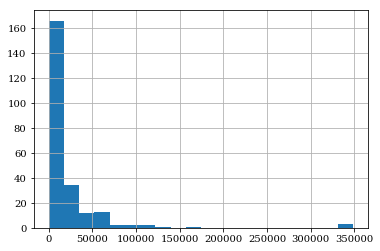

In [14]:
finalRes['dist'].hist(bins=20)

In [15]:
# interestingly there are other known annotated transcripts for these genes
# which may in fact overlap novel isoforms
# however, those transcripts do not have a corresponding CDS
# so perhaps it would be a better idea to separate them out into distinct genes????

In [16]:
# lastly, let's investigate cases where all known transcripts have a CDS - this way if something is outside - very susplicious

# what we should do is for each CDS group (cds that belong to the same gene)
# we need to intersect it with all known transcritpts for that gene
# if the set difference is 0 - that means all known transcripts in a gene have a CDS annotated
transIDs=pd.DataFrame([transIDs_known_only]).T
transIDs.columns=['id']
transIDs['cds']=transIDs['id'].isin(cdsParents_known_only)
transIDs['cds']=transIDs['cds'].astype(int)
transIDs['geneID']=transIDs.id.str.extract('(CHS.(\d)*)',expand=True)[0]
transIDs.head()

,id,cds,geneID
0,CHS.37542.44,1,CHS.37542
1,CHS.1638.6,1,CHS.1638
2,CHS.40717.13,1,CHS.40717
3,CHS.34617.5,1,CHS.34617
4,CHS.47197.10,1,CHS.47197


In [17]:
grouped=transIDs[['geneID','cds']].groupby(by='geneID').mean()
grouped.reset_index(inplace=True)
cdsOnlyGenes=set(grouped[grouped['cds']==1]["geneID"])
print(len(cdsOnlyGenes))

9870


In [18]:
# now need to select those from the finalRes dataframe
cdsOnlyOutOfBounds=finalRes[finalRes['geneID'].isin(cdsOnlyGenes)].reset_index(drop=True)
print(len(set(cdsOnlyOutOfBounds["parent"])))
print(len(set(cdsOnlyOutOfBounds["geneID"])))
display(cdsOnlyOutOfBounds[cdsOnlyOutOfBounds["parent"]=="CHS.36728.3"])
display(cdsOnlyOutOfBounds[cdsOnlyOutOfBounds['parent']=='CHS.51125.3'])
cdsOnlyOutOfBounds.head()

45
36


,geneID,smin_known,smax_known,emin_known,emax_known,parent,smin_novel,smax_novel,emin_novel,emax_novel,dist
2,CHS.36728,17962572,18267018,17962694,18268922,CHS.36728.3,18330788.0,18342247.0,18330962.0,18344196.0,61866.0


,geneID,smin_known,smax_known,emin_known,emax_known,parent,smin_novel,smax_novel,emin_novel,emax_novel,dist
25,CHS.51125,88759368,89333363,88760084,89337057,CHS.51125.3,88758022.0,88758970.0,88758521.0,88759367.0,1.0


,geneID,smin_known,smax_known,emin_known,emax_known,parent,smin_novel,smax_novel,emin_novel,emax_novel,dist
0,CHS.51962,138076432,138116620,138076611,138118304,CHS.51962.13,138001784.0,138004556.0,138002390.0,138007888.0,68544.0
1,CHS.51962,138076432,138116620,138076611,138118304,CHS.51962.15,138002270.0,138008838.0,138002390.0,138011346.0,65086.0
2,CHS.36728,17962572,18267018,17962694,18268922,CHS.36728.3,18330788.0,18342247.0,18330962.0,18344196.0,61866.0
3,CHS.51962,138076432,138116620,138076611,138118304,CHS.51962.14,138002214.0,138021187.0,138002390.0,138022179.0,54253.0
4,CHS.40180,37453454,37590088,37453830,37596146,CHS.40180.9,37615856.0,37622829.0,37619710.0,37624376.0,19710.0


In [19]:
# now we need to compute the same statistics for the known isoforms of known genes
# to see how frequently there are exons that do not overlap

df_known_exons=pd.read_csv("./chess2.02.gff",sep="\t",names=gff3Cols)
df_known_exons.dropna(1inplace=True,axis=0)
df_known_exons.reset_index(inplace=True,drop=True)
df_known_exons=df_known_exons[df_known_exons["type"]=="exon"].reset_index(drop=True)
df_known_exons["start"]=df_known_exons["start"].astype(int)
df_known_exons["end"]=df_known_exons["end"].astype(int)
df_known_exons=df_known_exons[~(df_known_exons['source'].isin(novelSources))].reset_index(drop=True)
df_known_exons["parent"]=df_known_exons.attributes.str.split("Parent=",expand=True)[1].str.split(";",expand=True)[0]
df_known_exons["geneID"]=df_known_exons.parent.str.extract('(CHS.(\d)*)',expand=True)[0]
df_known_exons=df_known_exons[df_known_exons["geneID"].isin(set(knownDF["geneID"]))].reset_index(drop=True)
df_known_exons.head()

,seqid,source,type,start,end,score,strand,phase,attributes,parent,geneID
0,chr1,BestRefSeq,exon,69091,70008,.,+,.,Parent=CHS.6.1,CHS.6.1,CHS.6
1,chr1,Gnomon,exon,181049,181110,.,+,.,Parent=CHS.9.1,CHS.9.1,CHS.9
2,chr1,Gnomon,exon,182529,182746,.,+,.,Parent=CHS.9.1,CHS.9.1,CHS.9
3,chr1,Gnomon,exon,183114,183240,.,+,.,Parent=CHS.9.1,CHS.9.1,CHS.9
4,chr1,Gnomon,exon,183922,184258,.,+,.,Parent=CHS.9.1,CHS.9.1,CHS.9


In [20]:
knownExonDF=df_known_exons.groupby("parent").agg({'start':['min','max'],'end':['min','max'],'geneID':'min'}).reset_index()
knownExonDF.columns=['parent','smin','smax','emin','emax','geneID']
knownExonDF.head()

,parent,smin,smax,emin,emax,geneID
0,CHS.10000.1,112961247,113262846,112961664,113265197,CHS.10000
1,CHS.10000.10,112961368,113262846,112961664,113263012,CHS.10000
2,CHS.10000.12,112961425,113040926,112961664,113041216,CHS.10000
3,CHS.10000.13,112961439,113133449,112961664,113133951,CHS.10000
4,CHS.10000.2,112961247,113262846,112961664,113265197,CHS.10000


In [26]:
# now merge the two together (novel with the known transcripts)
knownResDF=knownDF.merge(knownExonDF,on='geneID',how='outer',indicator=True)
assert len(knownResDF[(knownResDF['_merge']=='right_only')])==0,"something's wrong with the novel transcripts. Some don't match the known isoforms "
knownResDF=knownResDF[knownResDF['_merge']=='both'].reset_index(drop=True)
knownResDF.drop('_merge',inplace=True,axis=1)
knownResDF.columns=['geneID','smin_known','smax_known','emin_known','emax_known',
               'parent','smin_novel','smax_novel','emin_novel','emax_novel']
finalKnownResDF=knownResDF[(knownResDF['emax_novel']<knownResDF['smin_known'])|(knownResDF['smin_novel']>knownResDF['emax_known'])].reset_index(drop=True)
finalKnownResDF.head()

,geneID,smin_known,smax_known,emin_known,emax_known,parent,smin_novel,smax_novel,emin_novel,emax_novel
0,CHS.10363,126123806,126140119,126124484,126140638,CHS.10363.7,126100505,126100505,126102413,126102413
1,CHS.10621,280057,388927,285662,389455,CHS.10621.17,273954,273954,277123,277123
2,CHS.10680,2812621,2824090,2812856,2826197,CHS.10680.11,2830425,2836745,2830885,2836992
3,CHS.10698,3613366,3753015,3615439,3753216,CHS.10698.15,3610307,3610307,3612003,3612003
4,CHS.10725,4590072,4613515,4590105,4613888,CHS.10725.31,4567955,4572846,4568048,4573198


In [30]:
print(len(set(finalKnownResDF["parent"])))
print(len(set(finalKnownResDF["geneID"])))
# make sure all is correct by seeing if any transcripts overlap novel
# if difference is the same as the number of known transcripts - all good
assert len(set(finalKnownResDF["parent"]).difference(set(finalRes['parent'])))==len(set(finalKnownResDF["parent"])),"novel transcrits present"
finalKnownResDF["dist"]=np.where(finalKnownResDF['emax_novel']<finalKnownResDF['smin_known'],finalKnownResDF['smin_known']-finalKnownResDF['emax_novel'],finalKnownResDF['smin_novel']-finalKnownResDF['emax_known'])
finalKnownResDF.head()

288
221


,geneID,smin_known,smax_known,emin_known,emax_known,parent,smin_novel,smax_novel,emin_novel,emax_novel,dist
0,CHS.10363,126123806,126140119,126124484,126140638,CHS.10363.7,126100505,126100505,126102413,126102413,21393
1,CHS.10621,280057,388927,285662,389455,CHS.10621.17,273954,273954,277123,277123,2934
2,CHS.10680,2812621,2824090,2812856,2826197,CHS.10680.11,2830425,2836745,2830885,2836992,4228
3,CHS.10698,3613366,3753015,3615439,3753216,CHS.10698.15,3610307,3610307,3612003,3612003,1363
4,CHS.10725,4590072,4613515,4590105,4613888,CHS.10725.31,4567955,4572846,4568048,4573198,16874


In [31]:
finalKnownResDF.sort_values(by='dist',ascending=False,inplace=True)
finalKnownResDF.reset_index(drop=True,inplace=True)
finalKnownResDF.head()

,geneID,smin_known,smax_known,emin_known,emax_known,parent,smin_novel,smax_novel,emin_novel,emax_novel,dist
0,CHS.20405,79568021,79598785,79571350,79600725,CHS.20405.6,79212711,79229310,79212901,79229453,338568
1,CHS.12017,63142759,63149867,63145386,63152810,CHS.12017.8,63292625,63359876,63292936,63360037,139815
2,CHS.9672,86791059,86807884,86791195,86811233,CHS.9672.17,86940786,86951216,86940913,86951407,129553
3,CHS.9672,86791059,86807884,86791195,86811233,CHS.9672.18,86940786,86951216,86941027,86951736,129553
4,CHS.46819,80106610,80345975,80106683,80346270,CHS.46819.26,80466958,80466958,80469080,80469080,120688


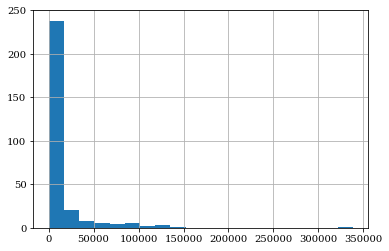

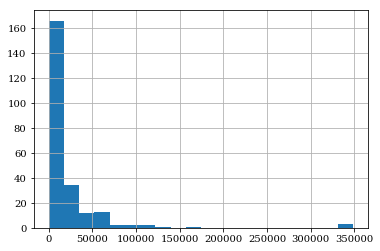

In [38]:
finalKnownResDF['dist'].hist(bins=20)
plt.show()
finalRes['dist'].hist(bins=20)

In [39]:
transIDs=pd.DataFrame([transIDs_known_only]).T
transIDs.columns=['id']
transIDs['cds']=transIDs['id'].isin(cdsParents_known_only)
transIDs['cds']=transIDs['cds'].astype(int)
transIDs['geneID']=transIDs.id.str.extract('(CHS.(\d)*)',expand=True)[0]
grouped=transIDs[['geneID','cds']].groupby(by='geneID').mean()
grouped.reset_index(inplace=True)
cdsOnlyGenes=set(grouped[grouped['cds']==1]["geneID"])
print(len(cdsOnlyGenes))
# now need to select those from the finalRes dataframe
cdsOnlyOutOfBounds=finalKnownResDF[finalKnownResDF['geneID'].isin(cdsOnlyGenes)].reset_index(drop=True)
print(len(set(cdsOnlyOutOfBounds["parent"])))
print(len(set(cdsOnlyOutOfBounds["geneID"])))
display(cdsOnlyOutOfBounds[cdsOnlyOutOfBounds["parent"]=="CHS.36728.3"])
display(cdsOnlyOutOfBounds[cdsOnlyOutOfBounds['parent']=='CHS.51125.3'])
cdsOnlyOutOfBounds.head()

9870
0
0


,geneID,smin_known,smax_known,emin_known,emax_known,parent,smin_novel,smax_novel,emin_novel,emax_novel,dist


,geneID,smin_known,smax_known,emin_known,emax_known,parent,smin_novel,smax_novel,emin_novel,emax_novel,dist


,geneID,smin_known,smax_known,emin_known,emax_known,parent,smin_novel,smax_novel,emin_novel,emax_novel,dist
